In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import re

In [ ]:
# Step 1: Load and Clean the Online Retail Dataset
retail_data = pd.read_csv("/content/online_retail.csv", encoding="ISO-8859-1")
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])
retail_data = retail_data.dropna(subset=['CustomerID'])


In [ ]:
# Define a snapshot date for recency calculation (latest transaction date + 1 day)
snapshot_date = retail_data['InvoiceDate'].max() + pd.Timedelta(days=1)

In [ ]:
# Step 2: RFM Analysis
rfm = retail_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'UnitPrice': lambda x: (x * retail_data.loc[x.index, 'Quantity']).sum()  # Monetary Value
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [ ]:
# Create a target variable: Customers who made another purchase in the next 30 days
future_purchases = retail_data[retail_data['InvoiceDate'] > snapshot_date - pd.Timedelta(days=30)]
future_customers = future_purchases['CustomerID'].unique()
rfm['Target'] = rfm.index.isin(future_customers).astype(int)

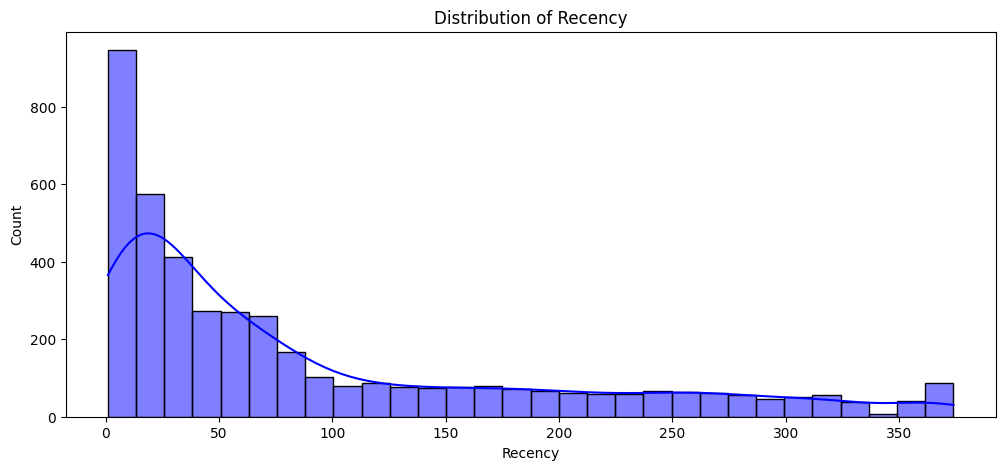

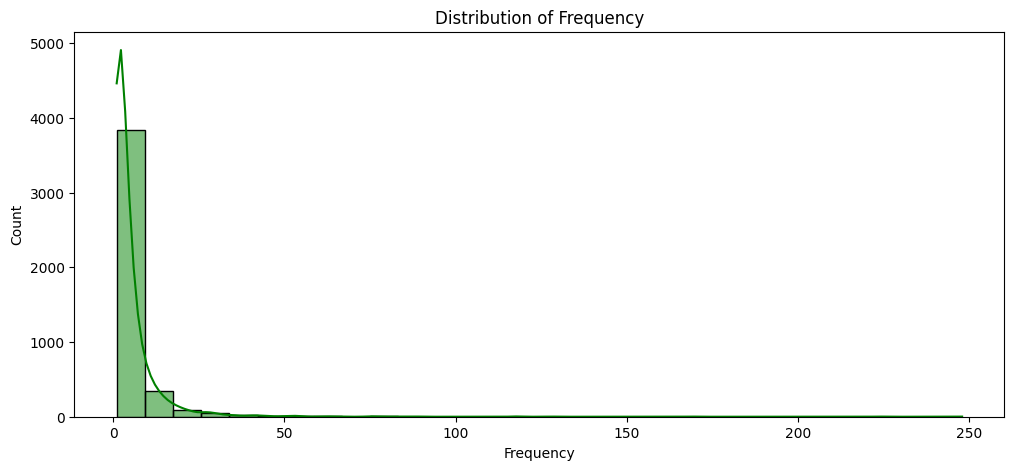

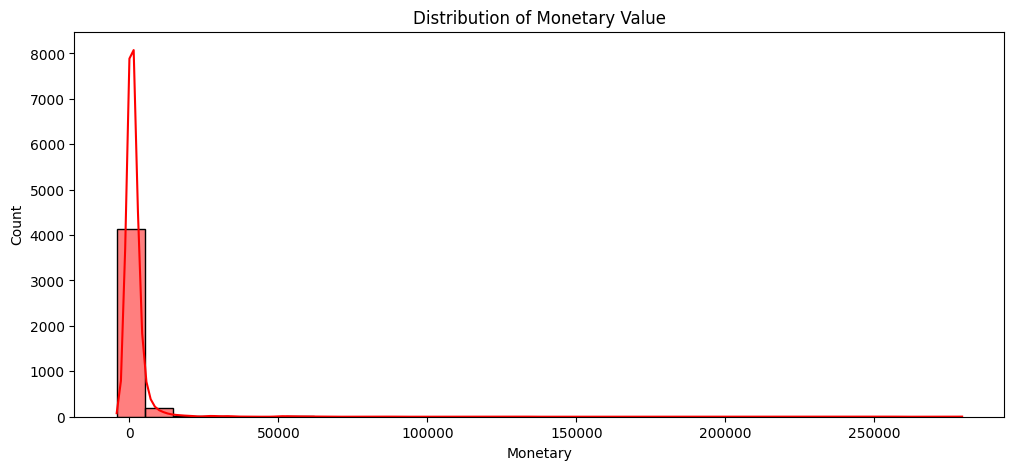

In [ ]:
# Visualization - RFM Distribution
plt.figure(figsize=(12,5))
sns.histplot(rfm['Recency'], bins=30, kde=True, color='blue')
plt.title('Distribution of Recency')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(rfm['Frequency'], bins=30, kde=True, color='green')
plt.title('Distribution of Frequency')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(rfm['Monetary'], bins=30, kde=True, color='red')
plt.title('Distribution of Monetary Value')
plt.show()

In [ ]:
# Step 3: Load and Clean the Reviews Dataset
reviews_data = pd.read_csv("/content/Reviews.csv", encoding="ISO-8859-1")
reviews_data.dropna(subset=['Text'], inplace=True)


In [ ]:
# Step 4: Sentiment Labeling
# Function to categorize scores into positive (1) and negative (0)
def sentiment_label(score):
    return 1 if score >= 4 else 0

reviews_data['Sentiment'] = reviews_data['Score'].apply(sentiment_label)

In [ ]:
# Step 5: Text Preprocessing for Sentiment Analysis
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    return text

reviews_data['Cleaned_Text'] = reviews_data['Text'].apply(preprocess_text)

<ipython-input-10-7d364a03fd4f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=reviews_data['Sentiment'], palette='coolwarm')


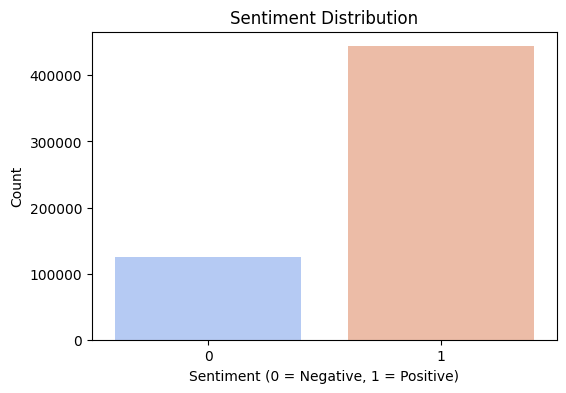

In [ ]:
# Visualization - Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=reviews_data['Sentiment'], palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Step 6: Convert Text into Numerical Features (TF-IDF)
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(reviews_data['Cleaned_Text']).toarray()
y_text = reviews_data['Sentiment']

In [ ]:
# Step 7: Train-Test Split for Sentiment Analysis
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(X_text, y_text, test_size=0.2, random_state=42)

In [ ]:
# Step 8: Train Logistic Regression Model for Sentiment Analysis
logistic_model = LogisticRegression()
logistic_model.fit(X_train_text, y_train_text)

LogisticRegression()

In [ ]:
# Predictions
y_pred_text = logistic_model.predict(X_test_text)

In [ ]:
# Evaluate Sentiment Analysis Model
accuracy_text = accuracy_score(y_test_text, y_pred_text)
report_text = classification_report(y_test_text, y_pred_text)
conf_matrix_text = confusion_matrix(y_test_text, y_pred_text)

In [ ]:
print(f'Sentiment Analysis Accuracy: {accuracy_text:.4f}')
print(report_text)

Sentiment Analysis Accuracy: 0.8765
              precision    recall  f1-score   support

           0       0.77      0.62      0.68     24666
           1       0.90      0.95      0.92     89025

    accuracy                           0.88    113691
   macro avg       0.83      0.78      0.80    113691
weighted avg       0.87      0.88      0.87    113691



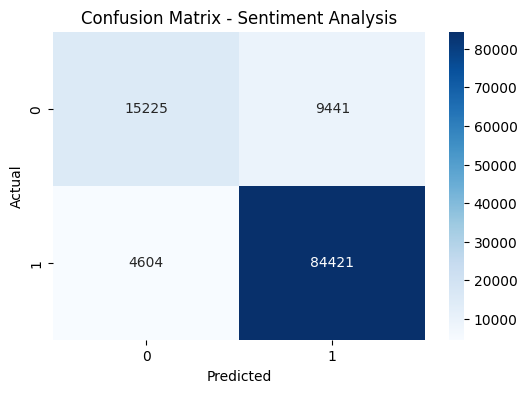

In [ ]:
# Visualization - Confusion Matrix for Sentiment Analysis
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_text, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Sentiment Analysis')
plt.show()

In [ ]:
# Step 9: Train-Test Split for Customer Acquisition Forecasting
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Step 10: Train Logistic Regression Model for Customer Acquisition
customer_model = LogisticRegression()
customer_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
# Predictions
y_pred_customer = customer_model.predict(X_test_scaled)


In [ ]:
# Evaluate Model for Customer Acquisition
accuracy_customer = accuracy_score(y_test, y_pred_customer)
report_customer = classification_report(y_test, y_pred_customer)
conf_matrix_customer = confusion_matrix(y_test, y_pred_customer)

In [ ]:
print(f'Customer Acquisition Forecasting Accuracy: {accuracy_customer:.4f}')
print(report_customer)

Customer Acquisition Forecasting Accuracy: 0.9806
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       545
           1       0.95      1.00      0.97       330

    accuracy                           0.98       875
   macro avg       0.98      0.98      0.98       875
weighted avg       0.98      0.98      0.98       875



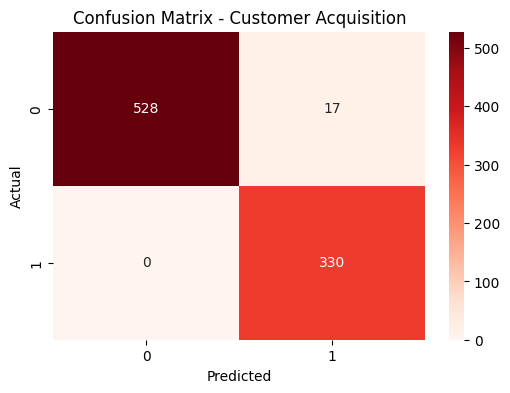

In [ ]:
# Visualization - Confusion Matrix for Customer Acquisition
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_customer, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Customer Acquisition')
plt.show()


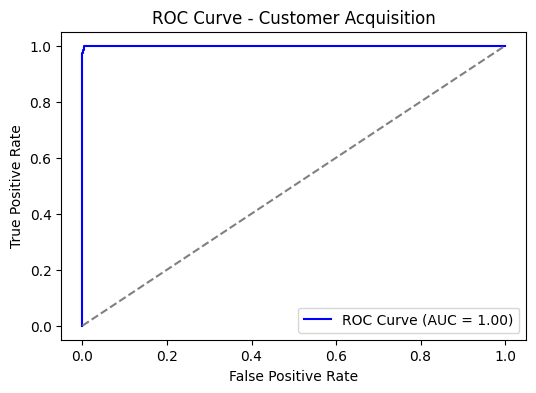

In [ ]:
# ROC Curve for Customer Acquisition
fpr, tpr, _ = roc_curve(y_test, customer_model.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Customer Acquisition')
plt.legend()
plt.show()